In [1]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

%matplotlib inline

In [2]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [3]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler.

In [5]:
# For DC2 gen3, these are the only optoins
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

butler = Butler(repo, collections=collection)
registry = butler.registry

In [6]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 70.1
deccen = -37.15

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
scatter_arcmin = 1.0

# "nfakes" is the number of fake stars to inject:
nfakes = 31

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = racen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)
fake_decs = deccen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)

# Make artificial u magnitudes in a range:
min_umag = 18.0
max_umag = 22.0
mag_scatter = 0.3
fake_umags = np.linspace(min_umag, max_umag, nfakes)

# Now assign magnitudes in other bands using (~fixed) colors:
fake_gmags = fake_umags - (1.0 + mag_scatter * np.random.randn(nfakes))  # distrib centered on u-g=1.0
fake_rmags = fake_gmags - (0.4 + mag_scatter * np.random.randn(nfakes))  # distrib centered on g-r=0.4
fake_imags = fake_rmags - (0.2 + mag_scatter * np.random.randn(nfakes))  # distrib centered on r-i=0.2

# These are totally arbitrary colors, but should be kinda similar to BHB stars?

In [7]:
import lsst.sphgeom

pixelization = lsst.sphgeom.HtmPixelization(18)

In [8]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=605158267899 at level=18 is a ~1.1" triangle.


In [9]:
#datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
#datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
#datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")
datasetRefs_coadd_i = registry.queryDatasets("deepCoadd_calexp", htm20=htm_id, band="i")

#print("Found ", datasetRefs_u.count(), " u-band calexps at that position.")
#print("Found ", datasetRefs_g.count(), " g-band calexps at that position.")
#print("Found ", datasetRefs_r.count(), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(), " i-band calexps at that position.")
print("Found ", datasetRefs_coadd_i.count(), " i-band coadds at that position.")

Found  107  i-band calexps at that position.
Found  1  i-band coadds at that position.


In [10]:
#for i, ref in enumerate(datasetRefs_u):
#    uref = ref
#    if i > 0:
#        break

#for i, ref in enumerate(datasetRefs_g):
#    gref = ref
#    if i > 0:
#        break

#for i, ref in enumerate(datasetRefs_r):
#    rref = ref
#    if i > 0:
#        break

for i, ref in enumerate(datasetRefs_i):
    if i > 0:
        break
    iref = ref

for i, ref in enumerate(datasetRefs_coadd_i):
    #if i > 0:
    #    break
    iref_coadd = ref
    print(i, ref)


0 deepCoadd_calexp@{band: 'i', skymap: 'DC2', tract: 3835, patch: 1}, sc=ExposureF] (id=3808862)


In [11]:
iref_coadd

DatasetRef(DatasetType('deepCoadd_calexp', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 3835, patch: 1}, id=3808862, run='2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy')

In [13]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [14]:
def addFakeStars(ras, decs, mags, calexp_ref):
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    calexp_withFakes = calexp_inp.clone()

    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()

    fluxes = []

    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    #xvals = []
    #yvals = []
    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
        #xvals.append(pos.x)
        #yvals.append(pos.y)

        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > y0 + psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > x0 + psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            image.getArray()[yslice, xslice] += objArray
            variance.getArray()[yslice, xslice] += noiseArray**2
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes

In [15]:
calexp_orig_i, calexp_new_i = addFakeStars(fake_ras, fake_decs, fake_imags, iref)

Injecting source at x, y =  1113.666000557719 469.5394306358621
Injecting source at x, y =  807.494779963354 523.4778526654263
Injecting source at x, y =  550.9892727618983 587.4198654343509
Injecting source at x, y =  311.1655984764259 439.367335671506
Injecting source at x, y =  442.12512759913716 348.90256737568825
Injecting source at x, y =  506.0771379995558 521.7636369010102
Skipped injecting source at x, y =  -74.48951396977463 705.2504766255188  because it is too close to (or off) the edge.
Injecting source at x, y =  918.1458285248646 290.618044770187
Injecting source at x, y =  995.1568989436498 402.37335218332396
Injecting source at x, y =  435.44355385776544 695.2363631286184
Injecting source at x, y =  680.837284097709 752.7882407973743
Injecting source at x, y =  421.17113761781275 442.2194088691017
Injecting source at x, y =  499.8229259280224 977.5489527224881
Injecting source at x, y =  824.3205221493467 508.8939839146228
Injecting source at x, y =  1015.0820832161369 

In [88]:
'''
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()

# Create a container which will be used to record metadata about algorithm execution
algMetadata = dafBase.PropertyList()

# Initialize CharacterizeImageTask and its configuration:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(None, config=config)

# Initialize SourceDetectionTask and its configuration:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10      # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask = SourceDeblendTask(schema=schema)

# Initialize SingleFrameMeasurementTask and its configuration:
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)
'''

In [193]:
'''
# Make an empty table that we'll put the results in:
tab = afwTable.SourceTable.make(schema)
    
# Image characterization
result = charImageTask.run(calexp_inp)

# Get the PSF and some image properties
psf = calexp_inp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

# The factor of 2.355 converts from std to fwhm
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
'''

"\n# Make an empty table that we'll put the results in:\ntab = afwTable.SourceTable.make(schema)\n    \n# Image characterization\nresult = charImageTask.run(calexp_inp)\n\n# Get the PSF and some image properties\npsf = calexp_inp.getPsf()\nsigma = psf.computeShape().getDeterminantRadius()\npixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()\n\n# The factor of 2.355 converts from std to fwhm\nprint('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))\n    \n"

In [194]:
'''
# Run source detection
result = sourceDetectionTask.run(tab, calexp_inp)
    
sources = result.sources
    
# Run source deblending
sourceDeblendTask.run(calexp_inp, sources)

# Run source measurement
sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

# The copy makes sure that the sources are sequential in memory
sources = sources.copy(True)
    
# For convenience, return an Astropy table:
source_tab = sources.asAstropy()
    
# Convert fluxes to magnitudes and add them to the table
photocalib = calexp_inp.getPhotoCalib()
psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
'''

"\n# Run source detection\nresult = sourceDetectionTask.run(tab, calexp_inp)\n    \nsources = result.sources\n    \n# Run source deblending\nsourceDeblendTask.run(calexp_inp, sources)\n\n# Run source measurement\nsourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)\n\n# The copy makes sure that the sources are sequential in memory\nsources = sources.copy(True)\n    \n# For convenience, return an Astropy table:\nsource_tab = sources.asAstropy()\n    \n# Convert fluxes to magnitudes and add them to the table\nphotocalib = calexp_inp.getPhotoCalib()\npsfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')\nsource_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])\n"

In [ ]:
# First, need to identify the coadd we want to use as a template:


In [190]:
# https://github.com/lsst/ip_diffim/blob/main/tests/test_imageDifference.py

from lsst.ip.diffim.imagePsfMatch import ImagePsfMatchTask, ImagePsfMatchConfig

config = ImagePsfMatchConfig()
alTask = ImagePsfMatchTask(config=config)

templateExposure = butler.get('deepCoadd_calexp', iref_coadd.dataId)
#scienceExposure = butler.get('calexp', iref.dataId)

#templateExposure = calexp_orig_i
scienceExposure = calexp_new_i

# The factor of 2.355 converts from std to fwhm
templateFwhmPix = 2.355*templateExposure.getPsf().computeShape().getDeterminantRadius()
scienceFwhmPix = 2.355*scienceExposure.getPsf().computeShape().getDeterminantRadius()

candidateList = None
result = alTask.subtractExposures(templateExposure, scienceExposure,
                                  templateFwhmPix=templateFwhmPix,
                                  scienceFwhmPix=scienceFwhmPix,
                                  doWarping=True,
                                  convolveTemplate=True,
                                  candidateList=candidateList,
                                 )

'''
    def wrapAlDiffim(config, templateExposure, scienceExposure, convolveTemplate=True, returnKernel=False,
                     precomputeKernelCandidates=False):
        """Prepare and run Alard&Lupton-style image differencing.
        Parameters
        ----------
        config : `lsst.pex.config.Config`
            The image differencing Task configuration settings.
        templateExposure : `lsst.afw.image.ExposureF`
            The reference image to subtract from the science image.
        scienceExposure : `lsst.afw.image.ExposureF`
            The science image.
        convolveTemplate : `bool`, optional
            Option to convolve the template or the science image.
        returnKernel : `bool`, optional
            Option to return the residual image or the matching kernel.
        Returns
        -------
        `lsst.afw.image.ExposureF` or `lsst.afw.math.LinearCombinationKernel`
            The image difference, or the PSF matching kernel.
        """
        alTask = ImagePsfMatchTask(config=config)
        candidateList = None
        if precomputeKernelCandidates:
            if convolveTemplate:
                candidateList = alTask.getSelectSources(scienceExposure.clone())
            else:
                candidateList = alTask.getSelectSources(templateExposure.clone())
        templateFwhmPix = templateExposure.getPsf().getSigma()
        scienceFwhmPix = scienceExposure.getPsf().getSigma()
        result = alTask.subtractExposures(templateExposure, scienceExposure,
                                          templateFwhmPix=templateFwhmPix,
                                          scienceFwhmPix=scienceFwhmPix,
                                          doWarping=False,
                                          convolveTemplate=convolveTemplate,
                                          candidateList=candidateList,
                                          )
        if returnKernel:
            return result.psfMatchingKernel
        else:
            return result.subtractedExposure
'''

/tmp/ipykernel_1840/3846926361.py:15: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  templateFwhmPix = 2.355*templateExposure.getPsf().computeShape().getDeterminantRadius()
/tmp/ipykernel_1840/3846926361.py:16: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  scienceFwhmPix = 2.355*scienceExposure.getPsf().computeShape().getDeterminantRadius()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


'\n    def wrapAlDiffim(config, templateExposure, scienceExposure, convolveTemplate=True, returnKernel=False,\n                     precomputeKernelCandidates=False):\n        """Prepare and run Alard&Lupton-style image differencing.\n        Parameters\n        ----------\n        config : `lsst.pex.config.Config`\n            The image differencing Task configuration settings.\n        templateExposure : `lsst.afw.image.ExposureF`\n            The reference image to subtract from the science image.\n        scienceExposure : `lsst.afw.image.ExposureF`\n            The science image.\n        convolveTemplate : `bool`, optional\n            Option to convolve the template or the science image.\n        returnKernel : `bool`, optional\n            Option to return the residual image or the matching kernel.\n        Returns\n        -------\n        `lsst.afw.image.ExposureF` or `lsst.afw.math.LinearCombinationKernel`\n            The image difference, or the PSF matching kernel.\n     

In [191]:
# result

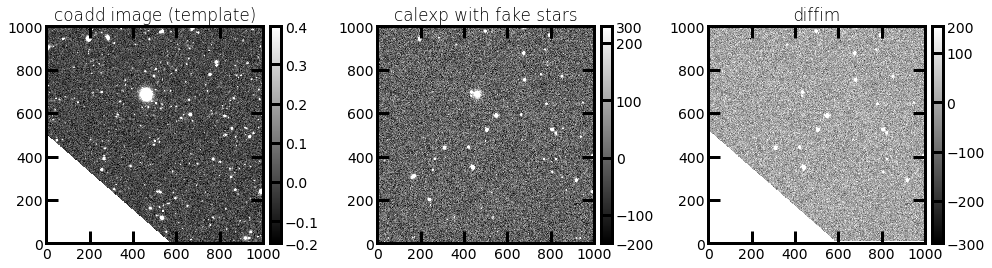

In [51]:
params = {'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)
fig, ax = plt.subplots(1, 3, figsize=(14, 11))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
#display1.mtv(calexp_orig_i.image)
display1.mtv(res.warpedExposure.image)
plt.title('coadd image (template)')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(calexp_new_i.image)
plt.title('calexp with fake stars')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.sca(ax[2])  # set the second axis as current
display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(res.subtractedExposure.image)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.title('diffim')
plt.tight_layout()
plt.show()

Notes: 

Ideally, want to use https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/getTemplate.py to get the template, rather than simply reading a `deepCoadd_calexp`.



In [197]:
from lsst.ap.pipe import ApPipeConfig, ApPipeTask

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+ce83317b7e/config/.dustmapsrc


In [198]:
ap_config = ApPipeConfig()

In [202]:
ap_config.differencer

In [16]:
# https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/imageDifference.py
from lsst.pipe.tasks.imageDifference import ImageDifferenceConfig, ImageDifferenceTask

In [56]:
imdiff_config = ImageDifferenceConfig()
# imdiff_config.doMatchSources = True  # match diaSources to the calexp
imdiff_task = ImageDifferenceTask(imdiff_config)

In [57]:
templateExposure = butler.get('deepCoadd_calexp', iref_coadd.dataId)
#scienceExposure = butler.get('calexp', iref.dataId)

#templateExposure = calexp_orig_i
scienceExposure = calexp_new_i

res = imdiff_task.run(exposure=scienceExposure, templateExposure=templateExposure)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


In [96]:
schema_res = res.diaSources.schema
sss = []
for s in schema_res:
    if 'ip_diffim' in s.field.getName():
        print(s)

(Key['Flag'](offset=32, bit=13), Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_flag", doc="general failure flag, set if anything went wrong"))
(Key['Flag'](offset=32, bit=14), Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_pos_flag", doc="failure flag for positive, set if anything went wrong"))
(Key['Flag'](offset=32, bit=15), Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_neg_flag", doc="failure flag for negative, set if anything went wrong"))
(Key<D>(offset=96, nElements=1), Field['D'](name="ip_diffim_NaiveDipoleCentroid_x", doc="unweighted first moment centroid: overall centroid", units="pixel"))
(Key<D>(offset=104, nElements=1), Field['D'](name="ip_diffim_NaiveDipoleCentroid_y", doc="unweighted first moment centroid: overall centroid", units="pixel"))
(Key<F>(offset=112, nElements=1), Field['F'](name="ip_diffim_NaiveDipoleCentroid_xErr", doc="1-sigma uncertainty on x position", units="pixel"))
(Key<F>(offset=116, nElements=1), Field['F'](name="ip_diffim_NaiveDipoleCentroi

In [139]:
pcalib = res.subtractedExposure.getPhotoCalib()
mags = pcalib.instFluxToMagnitude(res.diaSources, 'ip_diffim_forced_PsfFlux')
ap_mags = pcalib.instFluxToMagnitude(res.diaSources, 'slot_ApFlux')
#dipole_mags = pcalib.instFluxToMagnitude(res.diaSources, 'ip_diffim_DipoleFit_pos')

###??? Do I need to apply base_LocalPhotoCalib??? ###

dia_sources = res.diaSources.asAstropy()
dia_sources.add_columns([mags[:,0], mags[:,1]], names=['mag_psf', 'magerr_psf'])
dia_sources.add_columns([ap_mags[:,0], ap_mags[:,1]], names=['mag_ap', 'magerr_ap'])
#dia_sources.add_columns([dipole_mags[:,0], dipole_mags[:,1]], names=['mag_dipole', 'magerr_dipole'])


In [141]:
pcalib.instFluxToMagnitude?

Docstring:
instFluxToMagnitude(*args, **kwargs)
Overloaded function.

1. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, instFlux: float, point: lsst.geom.Point2D) -> float

2. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, instFlux: float) -> float

3. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, instFlux: float, instFluxErr: float, point: lsst.geom.Point2D) -> lsst.afw.image.Measurement

4. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, instFlux: float, instFluxErr: float) -> lsst.afw.image.Measurement

5. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, sourceRecord: lsst.afw.table.SourceRecord, instFluxField: str) -> lsst.afw.image.Measurement

6. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, sourceCatalog: lsst.afw.table.SourceCatalog, instFluxField: str) -> numpy.ndarray

7. instFluxToMagnitude(self: lsst.afw.image.PhotoCalib, sourceCatalog: lsst.afw.table.SourceCatalog, instFluxField: str, outField: str) -> None
Type:      method


In [142]:
dia_sources

id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakCentroid_flag,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,ip_diffim_NaiveDipoleCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PeakLikelihoodFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,ext_trailedSources_Naive_flag_badCentroid,slot_Centroid_flag,ip_diffim_NaiveDipoleCentroid_pos_flag,slot_Centroid_pos_flag,ip_diffim_NaiveDipoleCentroid_neg_flag,slot_Centroid_neg_flag,ip_diffim_NaiveDipoleCentroid_x,slot_Centroid_x,ip_diffim_NaiveDipoleCentroid_y,slot_Centroid_y,ip_diffim_NaiveDipoleCentroid_xErr,slot_Centroid_xErr,ip_diffim_NaiveDipoleCentroid_yErr,slot_Centroid_yErr,ip_diffim_NaiveDipoleCentroid_pos_x,slot_Centroid_pos_x,ip_diffim_NaiveDipoleCentroid_pos_y,slot_Centroid_pos_y,ip_diffim_NaiveDipoleCentroid_pos_xErr,slot_Centroid_pos_xErr,ip_diffim_NaiveDipoleCentroid_pos_yErr,slot_Centroid_pos_yErr,ip_diffim_NaiveDipoleCentroid_neg_x,slot_Centroid_neg_x,ip_diffim_NaiveDipoleCentroid_neg_y,slot_Centroid_neg_y,ip_diffim_NaiveDipoleCentroid_neg_xErr,slot_Centroid_neg_xErr,ip_diffim_NaiveDipoleCentroid_neg_yErr,slot_Centroid_neg_yErr,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape_xyErr,slot_Shape_xyErr,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_instFlux,slot_Shape_instFlux,base_SdssShape_instFluxErr,slot_Shape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_instFlux_xx_Cov,slot_Shape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,slot_Shape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,slot_Shape_instFlux_xy_Cov,base_SdssShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_SdssShape_flag_unweightedBad,base_GaussianFlux_flag_badShape_unweightedBad,slot_Shape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_GaussianFlux_flag_badShape_unweighted,slot_Shape_flag_unweighted,base_SdssShape_flag_shift,base_GaussianFlux_flag_badShape_shift,slot_Shape_flag_shift,base_SdssShape_flag_maxIter,base_GaussianFlux_flag_badShape_maxIter,slot_Shape_flag_maxIter,base_SdssShape_flag_psf,base_GaussianFlux_flag_badShape_psf,slot_Shape_flag_psf,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,slot_ApFlux_instFlux,base_CircularApertureFlux_12_0_ins

In [143]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
sc_withfakes_i = SkyCoord(ra=dia_sources['coord_ra'], dec=dia_sources['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

In [144]:
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

In [145]:
okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = dia_sources[idx_i]['mag_psf']
mch_magerrs_i = dia_sources[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
mch_mags_ap_i = dia_sources[idx_i]['mag_ap']
mch_magerrs_ap_i = dia_sources[idx_i]['magerr_ap']
mch_mags_ap_i[~okmch_i] = -99.9
mch_magerrs_ap_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec


In [146]:
tab_all = Table([fake_ras, fake_decs, fake_imags,
                 mch_mags_i, mch_magerrs_i, mch_mags_ap_i, mch_magerrs_ap_i, seps_i],
                 names=['ra', 'dec', 'i_fake', 'i_meas', 'ierr_meas',
                        'i_meas_ap', 'ierr_meas_ap', 'sep_i'],
                 units=[u.deg, u.deg, u.mag, u.mag, u.mag, u.mag, u.mag, u.arcsec])

for col in tab_all.colnames[0:2]:
    tab_all[col].info.format = '%.8g'  # for consistent table output
for col in tab_all.colnames[2:]:
    tab_all[col].info.format = '%.5g'  # for consistent table output


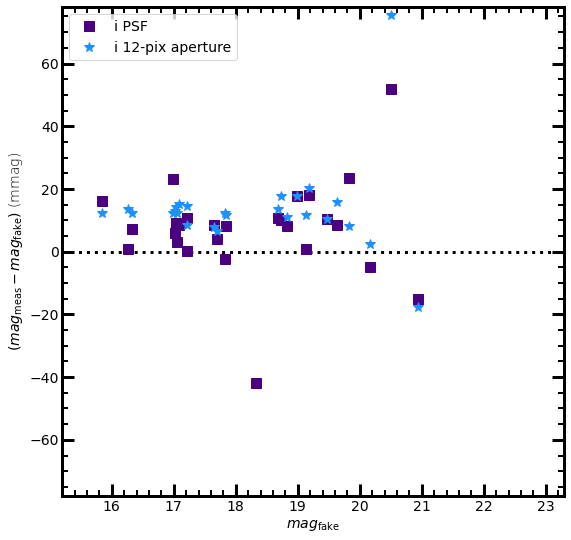

In [147]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(tab_all['i_fake'], 1000.0 * (tab_all['i_meas'] - tab_all['i_fake']),
         's', ms=10, color='indigo', label='i PSF')
plt.plot(tab_all['i_fake'], 1000.0 * (tab_all['i_meas_ap'] - tab_all['i_fake']),
         '*', ms=10, color='dodgerBlue', label='i 12-pix aperture')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 23.3)
plt.ylim(-78, 78)
plt.minorticks_on()
plt.show()

In [ ]:
# retrieveTemplate
# https://github.com/lsst/ap_pipe/blob/8f6ce01b843e3435af50b4fc2ff552a5e379b7ad/pipelines/ApPipe.yaml

from lsst.ip.diffim.getTemplate import GetTemplateTask

config_retrieveTemplate = GetTemplateTask.ConfigClass()
config_retrieveTemplate.connections.coaddName = parameters.coaddName
config_retrieveTemplate.connections.coaddExposures = parameters.template
config_retrieveTemplate.connections.outputExposure = parameters.templateExp

# Before imageDifference, need to initialize diaSrcSchema?

#retrieveTemplate:  # For multi-tract difference imaging
#    class: lsst.ip.diffim.getTemplate.GetTemplateTask
#    config:
#      connections.coaddName: parameters.coaddName
#      connections.coaddExposures: parameters.template
#      connections.outputExposure: parameters.templateExp
  imageDifference:
    class: lsst.pipe.tasks.imageDifference.ImageDifferenceFromTemplateTask
    config:
      doWriteWarpedExp: True             # Required for packaging alerts in diaPipe
      doSkySources: True
      coaddName: parameters.coaddName  # Can be removed once ImageDifference no longer supports Gen 2
      connections.coaddName: parameters.coaddName
      # TODO: redundant connection definitions workaround for DM-30210
      connections.coaddExposures: parameters.template
      connections.dcrCoadds: dcrCoadd
      connections.outputSchema: parameters.diaSrcSchema
      connections.subtractedExposure: parameters.diff
      connections.scoreExposure: parameters.diffScore
      connections.warpedExposure: parameters.diffWarp
      connections.matchedExposure: parameters.diffMatch
      connections.diaSources: parameters.diaSrcCat
      connections.inputTemplate: parameters.templateExp
      # TODO: end DM-30210 workaround